In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from sqlalchemy.exc import ProgrammingError
import json
import folium
import koreanize_matplotlib
from IPython.display import display
from scipy.stats import pearsonr, spearmanr

import geopandas as gpd
import folium

plt.rcParams["axes.unicode_minus"] = False


In [3]:
load_dotenv()

DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise RuntimeError("환경변수 DB_URL이 없습니다.")

engine = create_engine(DB_URL, future=True, pool_pre_ping=True)

with engine.connect() as conn:
    print("DB 연결 OK:", conn.execute(text("SELECT 1")).scalar_one() == 1)


DB 연결 OK: True


In [4]:
stmts = [

    # 1) 상권별 총매출(평일+주말 합)
    """
    CREATE OR REPLACE VIEW v_sales_area AS
    SELECT
      sc.year_quarter,
      sc.commercial_area_code,
      SUM(sd.sales) AS total_sales
    FROM Shop_Count sc
    JOIN Sales_Daytype sd     ON sd.store_id = sc.id
    JOIN Service_Category cat ON cat.code = sc.service_category_code
    WHERE cat.name IN (
      '한식음식점',
      '중식음식점',
      '일식음식점',
      '양식음식점',
      '제과점',
      '패스트푸드점',
      '치킨전문점',
      '분식전문점',
      '호프-간이주점',
      '커피-음료'
    )
    GROUP BY sc.year_quarter, sc.commercial_area_code
    """,

    # 2) 상권별 소득/지출 (Income = 동 단위 → 상권의 dong_code로 매핑)
    """
    CREATE OR REPLACE VIEW v_income_area AS
    SELECT
      i.year_quarter,
      ca.code AS commercial_area_code,
      i.monthly_income_avg,
      i.food_expenditure,
      i.total_expenditure
    FROM Commercial_Area ca
    JOIN Income i
      ON i.dong_code = ca.dong_code
    """,

    # 3) 개·폐업/경쟁강도(분기×상권)
    """
    CREATE OR REPLACE VIEW v_openclose_comp AS
    SELECT
      year_quarter,
      commercial_area_code,
      AVG(opened_percent)  AS opened_pct,
      SUM(opened_count)    AS opened_cnt,
      AVG(closed_percent)  AS closed_pct,
      SUM(closed_count)    AS closed_cnt,
      SUM(shop_count)      AS shop_cnt,
      SUM(similar_shop_count) AS similar_shop_cnt
    FROM Shop_Count
    GROUP BY year_quarter, commercial_area_code
    """,

    # 4) 유동인구(분기×상권)
    """
    CREATE OR REPLACE VIEW v_fpop_area AS
    SELECT
      year_quarter,
      commercial_area_code,
      total_pop
    FROM Floating_Population
    GROUP BY year_quarter, commercial_area_code, total_pop
    """,

    # 5) 최종 통합 뷰: 동일 분기 기준으로 조인
    """
    CREATE OR REPLACE VIEW v_area_join AS
    SELECT
      ca.code AS commercial_area_code,
      ca.name AS area_name,
      ca.gu,
      ca.dong,
      ca.lon,
      ca.lat,
      s.year_quarter,
      s.total_sales,
      inc.monthly_income_avg,
      inc.food_expenditure,
      oc.opened_pct,
      oc.closed_pct,
      oc.shop_cnt,
      oc.similar_shop_cnt,
      fp.total_pop
    FROM Commercial_Area ca
    LEFT JOIN v_sales_area s
      ON s.commercial_area_code = ca.code
    LEFT JOIN v_income_area inc
      ON inc.commercial_area_code = ca.code
     AND inc.year_quarter = s.year_quarter
    LEFT JOIN v_openclose_comp oc
      ON oc.commercial_area_code = ca.code
     AND oc.year_quarter = s.year_quarter
    LEFT JOIN v_fpop_area fp
      ON fp.commercial_area_code = ca.code
     AND fp.year_quarter = s.year_quarter
    """
]

from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise RuntimeError("환경변수 DB_URL이 없습니다. .env 로드/설정을 확인하세요.")
engine = create_engine(DB_URL, pool_pre_ping=True, future=True)

ok = True
with engine.begin() as conn:
    for i, sql in enumerate(stmts, 1):
        try:
            conn.execute(text(sql))
        except ProgrammingError as e:
            ok = False
            print(f"[ERR] statement #{i} 실패\nSQL:\n{sql}\n\n에러:\n{e}\n", file=sys.stderr)
            break

print("뷰 생성 완료" if ok else "뷰 생성 중 오류 발생")

뷰 생성 완료


In [5]:
with engine.connect() as conn:
    df = pd.read_sql(
        text("""
            SELECT
              year_quarter, commercial_area_code, area_name, gu, dong, lon, lat,
              total_sales, monthly_income_avg, food_expenditure,
              opened_pct, closed_pct, shop_cnt, similar_shop_cnt, total_pop
            FROM v_area_join
        """),
        engine
    )

print(sorted(df['year_quarter'].unique()))
print(df.shape)


[np.float64(20241.0), np.float64(20242.0), np.float64(20243.0), np.float64(20244.0), np.float64(nan)]
(6074, 15)


In [22]:
# === 서울 행정동 소득 Choropleth (통합본) ===
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import re
from sqlalchemy import text

# ---- 0) 데이터 준비: df_dx 없으면 생성 (Income+Dong에서 동별 분기 평균) ----
if 'df_dx' not in globals():
    sql_dong_all = """
    SELECT
      i.year_quarter,
      i.dong_code,
      d.name  AS dong_name,
      i.monthly_income_avg,
      i.total_expenditure,
      i.food_expenditure
    FROM Income i
    JOIN Dong d ON d.code = i.dong_code
    """
    df_dong_all = pd.read_sql(text(sql_dong_all), engine)
    df_dong_mean = (
        df_dong_all.groupby(["dong_code", "dong_name"], as_index=False)
          .agg(
              monthly_income_avg=("monthly_income_avg", "mean"),
              total_expenditure=("total_expenditure", "mean"),
              food_expenditure=("food_expenditure", "mean"),
              food_exp_sum=("food_expenditure", "sum"),
              total_exp_sum=("total_expenditure", "sum"),
          )
    )
    den = df_dong_mean["total_exp_sum"].astype(float)
    num = df_dong_mean["food_exp_sum"].astype(float)
    df_dong_mean["food_share"] = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=(den>0))
    df_dx = df_dong_mean[[
        "dong_code","dong_name","monthly_income_avg","total_expenditure","food_expenditure","food_share"
    ]].copy()

# ---- 1) GeoJSON 로드 & 구/동명 파싱 ----
geo_path = "../../data/서울_행정동_경계_2017.geojson"
gdf = gpd.read_file(geo_path).copy()
gdf["adm_cd"] = gdf["adm_cd"].astype(str)

def split_gu_dong(adm_nm: str):
    toks = str(adm_nm).split()
    gu = toks[1] if len(toks) >= 2 else None
    dong = toks[2] if len(toks) >= 3 else None
    return pd.Series({"gu": gu, "dong_geo": dong})

gdf[["gu","dong_geo"]] = gdf["adm_nm"].apply(split_gu_dong)

def norm(x):
    x = str(x)
    x = re.sub(r"\s+", "", x)
    x = re.sub(r"[()]", "", x)
    return x

# ---- 2) df_base 준비 + Commercial_Area에서 대표 gu 조인 ----
df_base = (
    df_dx[["dong_code","dong_name","monthly_income_avg"]]
      .dropna(subset=["monthly_income_avg"])
      .copy()
)
df_base["dong_code"] = df_base["dong_code"].astype(str)

sql = """
SELECT dong_code, gu, COUNT(*) AS cnt
FROM Commercial_Area
WHERE gu IS NOT NULL
GROUP BY dong_code, gu
"""
df_ca = pd.read_sql(text(sql), engine)
df_ca["dong_code"] = df_ca["dong_code"].astype(str)
df_ca = (df_ca.sort_values(["dong_code","cnt"], ascending=[True, False])
              .drop_duplicates(subset=["dong_code"])
              .loc[:, ["dong_code","gu"]])
df_base = df_base.merge(df_ca, on="dong_code", how="left")

# ---- 3) gu 결측 보정: GeoJSON 단일 동명 자동 + 수동(항동 포함) ----
uni = gdf.groupby("dong_geo")["gu"].nunique().reset_index(name="ngu")
unique_dongs = set(uni.loc[uni["ngu"]==1, "dong_geo"])
fallback = (gdf[gdf["dong_geo"].isin(unique_dongs)]
            .drop_duplicates(subset=["dong_geo"])[["dong_geo","gu"]]
            .set_index("dong_geo")["gu"].to_dict())

manual = {
    "행당2동": "성동구",
    "돈암1동": "성북구",
    "돈암2동": "성북구",
    "월계3동": "노원구",
    "하계2동": "노원구",
    "항동":   "구로구",
}

mask_na = df_base["gu"].isna()
df_base.loc[mask_na, "gu"] = df_base.loc[mask_na, "dong_name"].map(fallback)
mask_na = df_base["gu"].isna()
df_base.loc[mask_na, "gu"] = df_base.loc[mask_na, "dong_name"].map(manual)

print("[INFO] gu 결측:", int(df_base["gu"].isna().sum()))

# ---- 4) (gu, 동명) 정규화 매칭으로 adm_cd 획득 ----
left = df_base.copy()
left["dong_name_n"] = left["dong_name"].apply(norm)
left["gu_n"]        = left["gu"].apply(norm)

right = gdf[["adm_cd","gu","dong_geo"]].copy()
right["dong_geo_n"] = right["dong_geo"].apply(norm)
right["gu_n"]       = right["gu"].apply(norm)

map_cd = left.merge(
    right[["adm_cd","gu_n","dong_geo_n"]],
    left_on=["gu_n","dong_name_n"],
    right_on=["gu_n","dong_geo_n"],
    how="left"
)
print(f"[INFO] 매칭률: {(map_cd['adm_cd'].notna().mean()*100):.1f}% / 총 {len(map_cd)}건")

# ---- 5) Folium Choropleth (단계수 K로 조절) + 툴팁 레이어 ----
vals_df = map_cd[["adm_cd","monthly_income_avg"]].dropna(subset=["adm_cd"]).copy()
vals = vals_df["monthly_income_avg"].astype(float)

K = 15  # 색 단계 수(클래스 수). 7~9 권장. 필요시 바꾸세요.
qs = np.linspace(0, 1, K+1)
bins = np.quantile(vals, qs).tolist()
bins = sorted(set(bins))
if len(bins) < 3:
    bins = np.linspace(vals.min(), vals.max(), K+1).tolist()

m = folium.Map(location=[37.5665, 126.9780], zoom_start=11, tiles="cartodbpositron")
ch = folium.Choropleth(
    geo_data=gdf.to_json(),
    data=vals_df,
    columns=["adm_cd", "monthly_income_avg"],
    key_on="feature.properties.adm_cd",
    fill_color="YlOrRd",
    fill_opacity=0.85,
    line_opacity=0.4,
    nan_fill_color="#eeeeee",
    bins=bins,
    name=f"월평균소득({K}단계)"
).add_to(m)

# 툴팁(투명 레이어; income_label 포함 가능)
g_show = gdf.merge(vals_df, on="adm_cd", how="left").copy()
g_show["income_label"] = g_show["monthly_income_avg"].map(lambda v: f"{v:,.0f}" if pd.notnull(v) else "자료없음")

gj = folium.GeoJson(
    data=g_show.to_json(),
    name="행정동_툴팁",
    style_function=lambda x: {"color":"#666","weight":0.4,"fillOpacity":0.0},
    highlight_function=lambda x: {"weight":2,"color":"#333"}
).add_to(m)
folium.GeoJsonTooltip(
    fields=["adm_nm","adm_cd","income_label"],
    aliases=["동이름","동코드","월평균소득"],
    sticky=True
).add_to(gj)

folium.LayerControl().add_to(m)
m  # 노트북에서 바로 표시
# m.save("/mnt/data/income_map.html")


[INFO] gu 결측: 0
[INFO] 매칭률: 99.8% / 총 425건


In [31]:
# ==== 동(행정동)별 2024 외식업 매출 총합 → Choropleth(Blues) ====

# 1) 동별 2024 매출 총합 집계
sql_sales_dong_2024 = """
WITH area_year AS (
  SELECT s.commercial_area_code, SUM(s.total_sales) AS area_sales_2024
  FROM v_sales_area s
  WHERE s.year_quarter BETWEEN 20241 AND 20244
  GROUP BY s.commercial_area_code
)
SELECT
  ca.dong_code,
  d.name AS dong_name,
  ca.gu,
  SUM(ay.area_sales_2024) AS sales_sum_2024
FROM area_year ay
JOIN Commercial_Area ca ON ca.code = ay.commercial_area_code
JOIN Dong d ON d.code = ca.dong_code
GROUP BY ca.dong_code, d.name, ca.gu
"""
df_sales_dong = pd.read_sql(text(sql_sales_dong_2024), engine)
df_sales_dong["dong_code"] = df_sales_dong["dong_code"].astype(str)

# 2) (gu, 동이름) 정규화 후 GeoJSON과 매칭하여 adm_cd 획득
left_sales = df_sales_dong.copy()
left_sales["dong_name_n"] = left_sales["dong_name"].apply(norm)
left_sales["gu_n"]        = left_sales["gu"].apply(norm)

# right: 위에서 이미 만든 GeoJSON 메타 (gu_n, dong_geo_n, adm_cd)
# right = gdf[["adm_cd","gu","dong_geo"]].copy(); right["dong_geo_n"] = right["dong_geo"].apply(norm); right["gu_n"] = right["gu"].apply(norm)

sales_map = left_sales.merge(
    right[["adm_cd","gu_n","dong_geo_n"]],
    left_on=["gu_n","dong_name_n"],
    right_on=["gu_n","dong_geo_n"],
    how="left"
)

print(f"[INFO] 매출-행정동 매칭률: {(sales_map['adm_cd'].notna().mean()*100):.1f}% / 총 {len(sales_map)}건")

# 3) Choropleth: 2024 동별 매출 총합 (파란색 단계)
vals_sales = sales_map[["adm_cd","sales_sum_2024"]].dropna(subset=["adm_cd"]).copy()
vals_sales["sales_sum_2024"] = pd.to_numeric(vals_sales["sales_sum_2024"], errors="coerce")

K_sales = 15  # 단계 수
vs = vals_sales["sales_sum_2024"].dropna().astype(float)
qs  = np.linspace(0, 1, K_sales+1)
bins_sales = np.quantile(vs, qs).tolist()
bins_sales = sorted(set(bins_sales))
if len(bins_sales) < 3:  # 값이 적으면 등분
    bins_sales = np.linspace(vs.min(), vs.max(), K_sales+1).tolist()

m2 = folium.Map(location=[37.5665, 126.9780], zoom_start=11, tiles="cartodbpositron")

folium.Choropleth(
    geo_data=gdf.to_json(),
    data=vals_sales,
    columns=["adm_cd", "sales_sum_2024"],
    key_on="feature.properties.adm_cd",
    fill_color="Blues",            # ← 파란색 단계
    fill_opacity=0.85,
    line_opacity=0.4,
    nan_fill_color="#eeeeee",
    bins=bins_sales,
    name=f"2024 외식업 매출 총합({K_sales}단계)"
).add_to(m2)

# 4) 툴팁(동명/코드/매출)
g_show2 = gdf.merge(vals_sales, on="adm_cd", how="left").copy()
g_show2["sales_label"] = g_show2["sales_sum_2024"].map(lambda v: f"{v:,.0f}" if pd.notnull(v) else "자료없음")

gj2 = folium.GeoJson(
    data=g_show2.to_json(),
    name="행정동_툴팁(매출)",
    style_function=lambda x: {"color":"#666","weight":0.4,"fillOpacity":0.0},
    highlight_function=lambda x: {"weight":2,"color":"#333"}
).add_to(m2)
folium.GeoJsonTooltip(
    fields=["adm_nm","adm_cd","sales_label"],
    aliases=["동이름","동코드","2024 매출(외식)"],
    sticky=True
).add_to(gj2)

folium.LayerControl().add_to(m2)
m2  # 노트북에서 바로 표시
# m2.save("/mnt/data/sales_2024_map.html")


[INFO] 매출-행정동 매칭률: 99.7% / 총 394건


### 2024 총 지출, 음식지출, 동 내 총 상권 매출, 동 내 상권 매출 평균

In [8]:
# 1) 동 단위 소득/지출 — 2024 연간 집계
sql_dong_2024 = """
SELECT
  i.dong_code,
  d.name AS dong_name,
  AVG(i.monthly_income_avg)   AS monthly_income_avg,  -- 2024 평균
  SUM(i.total_expenditure)    AS total_expenditure,   -- 2024 총합
  SUM(i.food_expenditure)     AS food_expenditure     -- 2024 총합
FROM Income i
JOIN Dong d ON d.code = i.dong_code
WHERE i.year_quarter BETWEEN 20241 AND 20244
GROUP BY i.dong_code, d.name
"""
df_dong_2024 = pd.read_sql(text(sql_dong_2024), engine)

# 2024 음식지출 비중 (합/합)
df_dong_2024["food_share"] = (
    df_dong_2024["food_expenditure"] / df_dong_2024["total_expenditure"]
).where(df_dong_2024["total_expenditure"].fillna(0) > 0)

# 2) 동 매출(외식 10종) — 2024 총합 & 2024 상권 평균
#    v_sales_area: (외식10종 필터 적용된) 분기×상권 총매출
sql_sales_by_dong_2024 = """
WITH area_year AS (
  -- 상권별 2024 연간 매출(4분기 합)
  SELECT
    s.commercial_area_code,
    SUM(s.total_sales) AS area_sales
  FROM v_sales_area s
  WHERE s.year_quarter BETWEEN 20241 AND 20244
  GROUP BY s.commercial_area_code
),
dong_area AS (
  -- 상권 -> 동 매핑
  SELECT
    ca.dong_code,
    ay.area_sales
  FROM area_year ay
  JOIN Commercial_Area ca
    ON ca.code = ay.commercial_area_code
)
SELECT
  dong_code,
  SUM(area_sales)                AS sales_sum_area,   -- 동 내 상권 총매출(연간 합)
  AVG(area_sales)                AS sales_avg_area,   -- 동 내 상권 매출 평균(연간 합의 상권평균)
  COUNT(*)                            AS area_cnt          -- 동 내 상권 수(2024에 관측된 상권)
FROM dong_area
GROUP BY dong_code
"""
df_sales_dong_2024 = pd.read_sql(text(sql_sales_by_dong_2024), engine)

# 3) 병합 (dong_code 기준, 2024 전용)
df_dx_2024 = df_dong_2024.merge(df_sales_dong_2024, on="dong_code", how="left")

fmt_money = {
    "monthly_income_avg": "{:,.0f}",
    "total_expenditure": "{:,.0f}",
    "food_expenditure": "{:,.0f}",
    "sales_sum_area": "{:,.0f}",
    "sales_avg_area": "{:,.0f}",
}
fmt_ratio = {"food_share": "{:.1%}"}
fmt_count = {"area_cnt": "{:,.0f}"}

cols = [
    "dong_name",
    "monthly_income_avg",
    "total_expenditure", "food_expenditure", "food_share",
    "sales_sum_area", "sales_avg_area", "area_cnt",
]

# 4) 정렬·표시
df_sorted = df_dx_2024.sort_values("monthly_income_avg", ascending=False)
top20   = df_sorted.head(20).copy()
bottom10 = df_dx_2024.nsmallest(10, "monthly_income_avg").copy()

print("소득 상위 20개 동 (지표: 2024 연간 합/평균 기준)")
display(
    top20[cols].reset_index(drop=True)
         .style.format({**fmt_money, **fmt_ratio, **fmt_count})
         .set_properties(subset=["dong_name"], **{"font-weight": "bold"})
)

print("소득 하위 10개 동 (지표: 2024 연간 합/평균 기준)")
display(
    bottom10[cols].reset_index(drop=True)
            .style.format({**fmt_money, **fmt_ratio, **fmt_count})
            .set_properties(subset=["dong_name"], **{"font-weight": "bold"})
)


소득 상위 20개 동 (지표: 2024 연간 합/평균 기준)


소득 하위 10개 동 (지표: 2024 연간 합/평균 기준)


-> 고소득 지역에 상권이 부재하는 경우가 있어서 20개로 출력 늘림
고소득 지역이 주거 위주로 형성되어 있다는 것을 시사. 

In [9]:
dfv = df_dx_2024.copy()

# 매출 NaN(상권 없음) → 0으로 표시(시각화 안정성)
for c in ["sales_sum_area", "sales_avg_area", "area_cnt"]:
    if c in dfv.columns:
        dfv[c] = dfv[c].fillna(0)

# 버블 사이즈 스케일 (상권 수)
def scale_radius(x, rmin=6, rmax=28):
    if len(x) == 0:
        return x
    x = x.astype(float)
    # 분위수 5~95%로 클리핑해서 극단치 완화
    lo, hi = np.nanpercentile(x, 5), np.nanpercentile(x, 95)
    if hi <= lo:
        return np.full_like(x, (rmin+rmax)/2)
    return np.clip(rmin + (x - lo) * (rmax - rmin) / (hi - lo), rmin, rmax)

dfv["bubble_size"] = scale_radius(dfv["area_cnt"].fillna(0))

# 툴팁용 문자열
dfv["hover"] = (
    "동: " + dfv["dong_name"].astype(str)
    + "<br>월평균 소득: " + dfv["monthly_income_avg"].map("{:,.0f}".format)
    + "<br>총지출(연): " + dfv["total_expenditure"].map("{:,.0f}".format)
    + "<br>음식지출(연): " + dfv["food_expenditure"].map("{:,.0f}".format)
    + "<br>식비비중: " + (dfv["food_share"]*100).map("{:.1f}%".format)
    + "<br>상권 총매출(연): " + dfv["sales_sum_area"].map("{:,.0f}".format)
    + "<br>상권 평균매출(연): " + dfv["sales_avg_area"].map("{:,.0f}".format)
    + "<br>상권 수: " + dfv["area_cnt"].map("{:,.0f}".format)
)


In [10]:
import plotly.express as px

fig = px.scatter(
    dfv,
    x="monthly_income_avg", y="sales_sum_area",
    size="bubble_size", color="food_share",
    color_continuous_scale="Tealrose",
    hover_name="dong_name", hover_data={"bubble_size":False, "food_share":True},
    custom_data=["hover"],
    labels={
        "monthly_income_avg": "월평균 소득",
        "sales_sum_area": "동 내 상권 총매출(연)",
        "food_share": "식비비중",
    },
    title="월평균 소득 ↔ 동 내 상권 총매출(연) · 버블=상권 수 · 색=식비비중"
)
# 툴팁 커스터마이즈
fig.update_traces(hovertemplate="%{customdata[0]}")

fig.update_xaxes(type="log", title_standoff=5)
fig.update_yaxes(type="log", title_standoff=5)

fig.update_layout(
    height=540,
    legend_title_text="식비비중",
    coloraxis_colorbar=dict(title="식비비중"),
    margin=dict(l=10,r=10,t=60,b=10),
    template="plotly_white",
)
fig.show()


In [16]:
import plotly.graph_objects as go

topN = 15
t = dfv.sort_values("sales_sum_area", ascending=False).head(topN).iloc[::-1]  # 역순 for horizontal

fig = go.Figure()

# 막대: 동 내 상권 총매출(연)
fig.add_bar(
    x=t["sales_sum_area"], y=t["dong_name"],
    orientation="h", name="총매출(연)",
    hovertext=t["hover"], hoverinfo="text"
)

# 선+점: 동 내 상권 평균매출(연)  → 같은 x축 사용!
fig.add_scatter(
    x=t["sales_avg_area"], y=t["dong_name"],
    mode="lines+markers", name="상권 평균매출(연)",
    line=dict(width=2), marker=dict(size=8)
)

fig.update_layout(
    title="동 내 상권 총매출(연) · 평균매출(연) TOP 15",
    barmode="overlay",
    height=640, template="plotly_white",
    xaxis=dict(title="금액(연)", side="bottom", rangemode="tozero", showgrid=True),
    yaxis=dict(title=None),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=90, r=30, t=70, b=40),
)

fig.show()


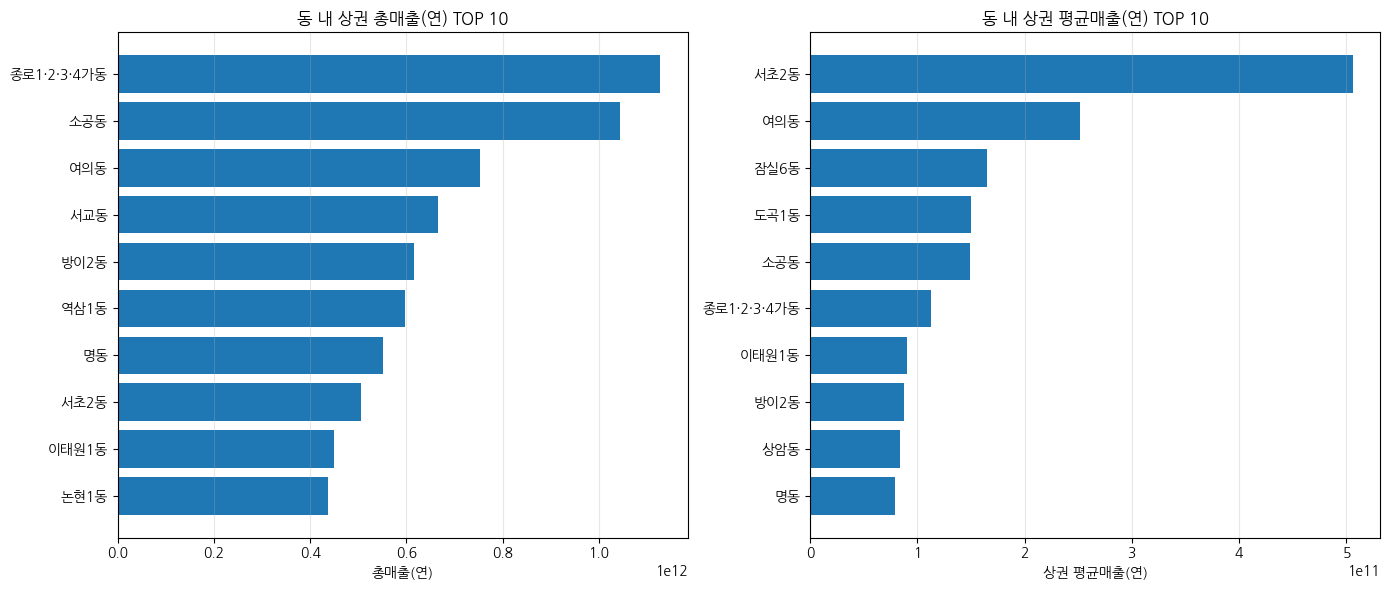

In [13]:
left = dfv.sort_values("sales_sum_area", ascending=False).head(10)
right = dfv.sort_values("sales_avg_area", ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# 왼쪽: 총매출(연)
axes[0].barh(left["dong_name"][::-1], left["sales_sum_area"][::-1])
axes[0].set_title("동 내 상권 총매출(연) TOP 10")
axes[0].set_xlabel("총매출(연)")

# 오른쪽: 상권 평균매출(연)
axes[1].barh(right["dong_name"][::-1], right["sales_avg_area"][::-1])
axes[1].set_title("동 내 상권 평균매출(연) TOP 10")
axes[1].set_xlabel("상권 평균매출(연)")

for ax in axes:
    ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


sales_sum_area와 sales_avg_area가 모두 큰 동은 “동 전체 시장 규모”도 크고, 동 내에 속한 “상권당 매출”도 높은 것.

area_cnt가 1인데 sales_sum_area가 큰 경우는 단일 거대 상권. (서초2동, 대치1동)

food_share가 높고 sales_sum_area도 높다면, 소비 지갑의 외식 쏠림 + 상권 매출이 함께 높은 케이스(외식 친화도)로 볼 수 있음. -> 긍정적인 지표

In [19]:
def corr_pair(df, x, y, log=False):
    t = df[[x, y]].dropna().astype(float)
    n = len(t)
    if n < 3:
        return {"pearson": None, "spearman": None, "n": n}

    X = t[x].to_numpy()
    Y = t[y].to_numpy()
    if log:
        X = np.log1p(X)
        Y = np.log1p(Y)

    return {
        "pearson": round(pearsonr(X, Y)[0], 3),
        "spearman": round(spearmanr(X, Y)[0], 3),
        "n": n
    }

# 총매출(sales_sum_area) 쪽은 로그로 본다
pairs_mean_log = [
    ("소득 vs 상권매출(총매출)",       "monthly_income_avg", "sales_sum_area", True),
    ("총지출 vs 상권매출(총매출)",     "total_expenditure",  "sales_sum_area", True),
    ("음식지출 vs 상권매출(총매출)",   "food_expenditure",   "sales_sum_area", True),
    ("지출비중 vs 상권매출(총매출)",   "food_share",         "sales_sum_area", True),
]

print("상관관계 (피어슨/스피어만, 표본수 n)  ※ log1p 적용")
for name, x, y, log_flag in pairs_mean_log:
    c = corr_pair(df_dx_2024, x, y, log=log_flag)
    suf = " (log1p)" if log_flag else ""
    print(f"- {name}{suf}: pearson={c['pearson']}, spearman={c['spearman']}, n={c['n']}")


상관관계 (피어슨/스피어만, 표본수 n)  ※ log1p 적용
- 소득 vs 상권매출(총매출) (log1p): pearson=0.132, spearman=0.152, n=394
- 총지출 vs 상권매출(총매출) (log1p): pearson=0.692, spearman=0.755, n=394
- 음식지출 vs 상권매출(총매출) (log1p): pearson=0.841, spearman=0.836, n=394
- 지출비중 vs 상권매출(총매출) (log1p): pearson=0.123, spearman=0.197, n=394


소득 ↔ 총매출: 상관관계 약함 (r=0.132, ρ=0.152)
동 평균소득은 상권 총매출 설명력이 거의 없음
고소득 동이라도 주거 중심이면 상권 규모가 작을 수 있고, 소비가 다른 동(근무·유흥·관광지)에서 일어날 수 있음.
⇒ 입지/매출 예측 변수로 ‘소득’ 단독은 추천하지 않음

총지출 ↔ 총매출: 강함 (r=0.692, ρ=0.755)
동 단위 총지출 규모가 클수록 상권 총매출도 크다는 강한 단조·준선형 관계
“시장 크기(지갑 총량) ↔ 상권 매출”의 직관과 부합.
⇒ 시장규모 지표(총지출)는 강력한 1차 스크리닝 변수로 유효

음식지출 ↔ 총매출: 매우 강함 (r=0.841, ρ=0.836)
외식/식비 지출이 클수록 상권 매출이 특히 잘 오른다는 신호입니다.
상권 매출에서 F&B 비중이 크다는 구조적 특성을 반영.
⇒ 입지평가·매출모형에서 최우선 핵심 변수로 추천

식비 비중(food_share) ↔ 총매출: 무의미에 가까움 (r=0.123, ρ=0.197)
지출의 ‘구성비’는 총매출과 거의 관련 없음.
고소득·고매출 지역일수록 식비 비중은 약해지는 경향(절대액은 크지만 지출구성에서 비중은 낮아짐).
저소득 지역일수록 엥겔 지수가 높다는 것.
⇒ 비중보다 ‘절대액(음식지출)’을 고려해야 함

-> 비즈니스 시사점
시장규모(총지출) 큰 곳일수록 음식지출 절대액 크게 동반 상승함 → 외식업 상권 잠재력 높음
소득 변수는 직접적 설명력 낮음 → 입지 평가 시 보조 변수로 취급, 총지출·음식지출 중심 설계 권장

In [20]:
def corr_report(df, x, y):
    
    t = df[[x, y]].dropna().astype(float)
    n = len(t)
    if n < 3:
        print(f"- {x} vs {y}: 표본수 부족(n={n})")
        return
    X, Y = t[x].to_numpy(), t[y].to_numpy()

    # RAW
    p_raw = pearsonr(X, Y)[0]
    s_raw = spearmanr(X, Y)[0]

    # LOG1P
    Xl, Yl = np.log1p(X), np.log1p(Y)
    p_log = pearsonr(Xl, Yl)[0]
    s_log = spearmanr(Xl, Yl)[0]

    print(f"[{x} vs {y}] n={n}")
    print(f"  - Pearson (raw)   : {p_raw:.3f}   | Spearman (raw)   : {s_raw:.3f}")
    print(f"  - Pearson (log1p) : {p_log:.3f}   | Spearman (log1p) : {s_log:.3f}")

# 1) 소득 ↔ 총지출
corr_report(df_dx_2024, "monthly_income_avg", "total_expenditure")

# 2) 총지출 ↔ 음식지출
corr_report(df_dx_2024, "total_expenditure", "food_expenditure")


[monthly_income_avg vs total_expenditure] n=425
  - Pearson (raw)   : 0.146   | Spearman (raw)   : 0.197
  - Pearson (log1p) : 0.237   | Spearman (log1p) : 0.197
[total_expenditure vs food_expenditure] n=425
  - Pearson (raw)   : 0.322   | Spearman (raw)   : 0.911
  - Pearson (log1p) : 0.818   | Spearman (log1p) : 0.911


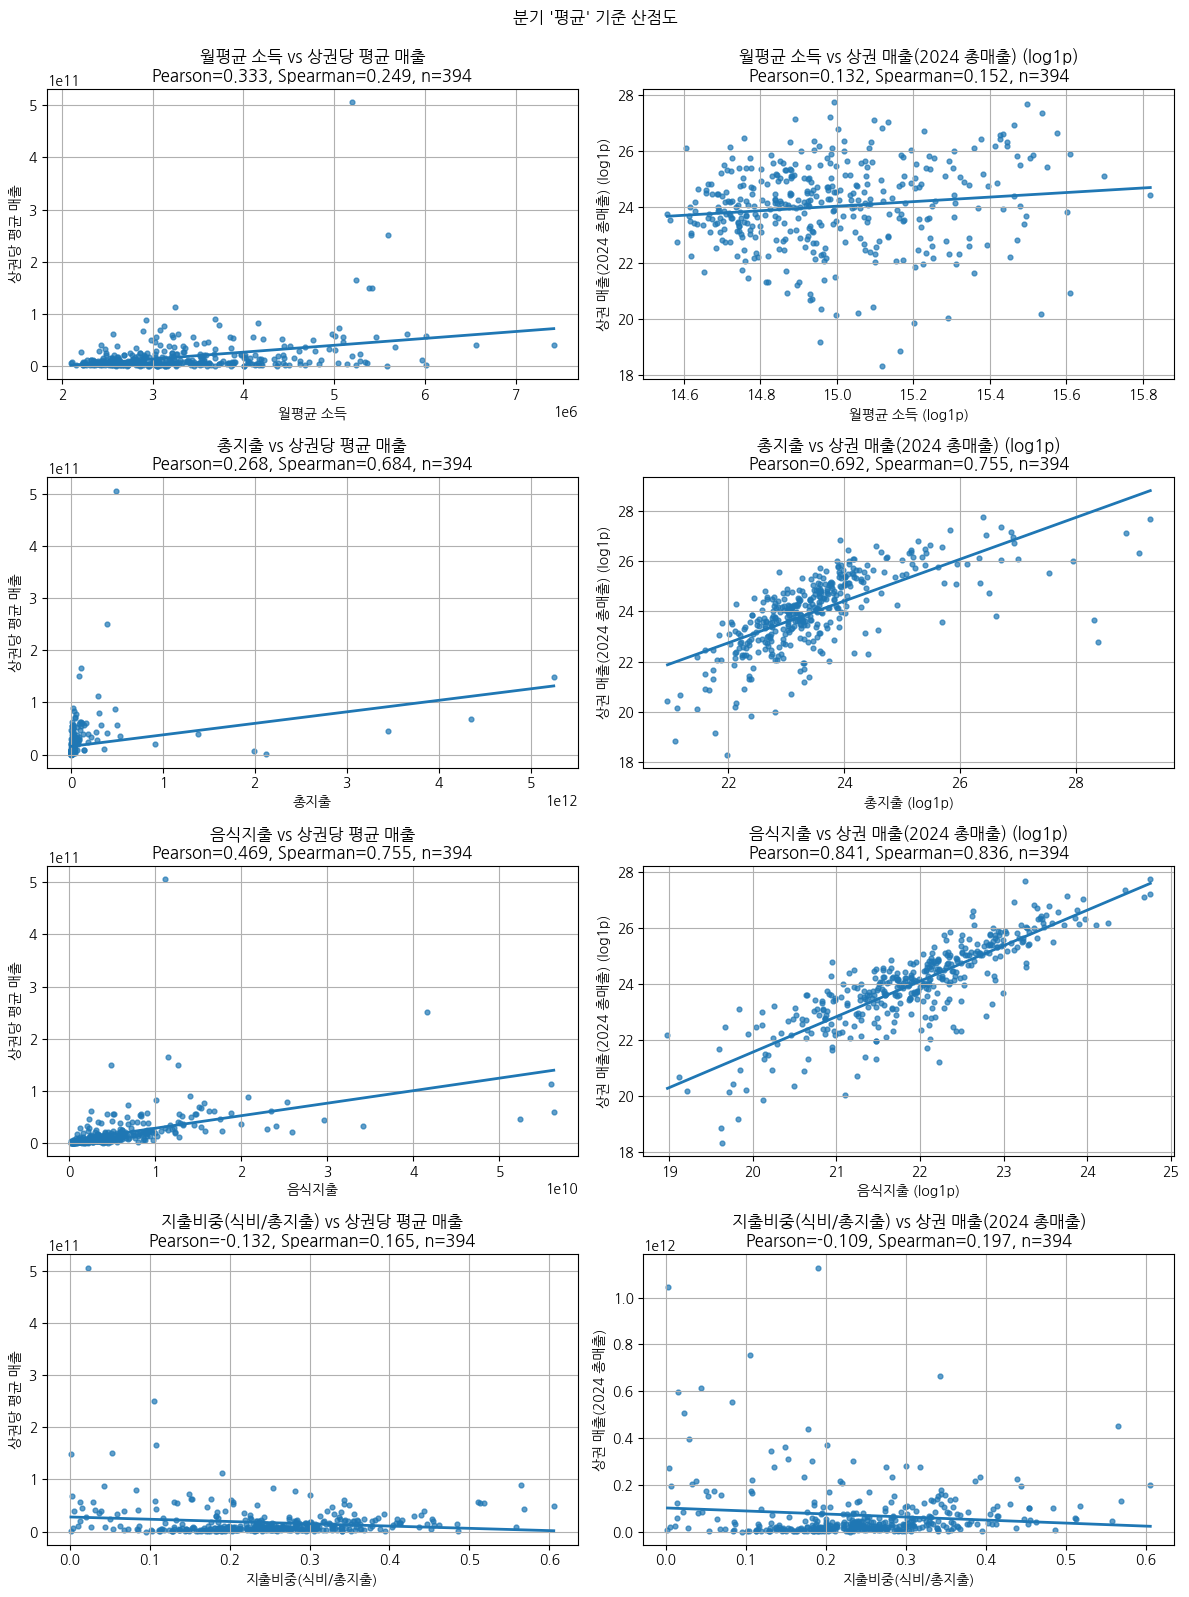

In [21]:
label_map = {
    "monthly_income_avg": "월평균 소득",
    "total_expenditure": "총지출",
    "food_expenditure": "음식지출",
    "food_share": "지출비중(식비/총지출)",
    "sales_avg_area": "상권당 평균 매출",
    "sales_sum_area": "상권 매출(2024 총매출)",
}

def plot_corr_grid(df, pairs, title="", ncols=2):
    """
    pairs: [(x, y, log_bool), ...]
    2열 그리드로 산점도+회귀선+상관수치 표시
    """
    def _corr_numbers(x, y):
        t = np.array([x, y], dtype=float).T
        t = t[~np.isnan(t).any(axis=1)]
        if len(t) < 3:
            return None, None, len(t)
        return pearsonr(t[:,0], t[:,1])[0], spearmanr(t[:,0], t[:,1])[0], len(t)

    n = len(pairs)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.reshape(nrows, ncols).ravel()

    for i, (x, y, log) in enumerate(pairs):
        ax = axes[i]
        t = df[[x, y]].dropna().copy()
        if len(t) < 3:
            ax.axis("off")
            ax.set_title(f"[SKIP] {x} vs {y} (n={len(t)})")
            continue

        X = t[x].values.astype(float)
        Y = t[y].values.astype(float)
        if log:
            Xp = np.log1p(X); Yp = np.log1p(Y); suffix = " (log1p)"
        else:
            Xp, Yp = X, Y;     suffix = ""

        # 상관수치
        p, s, nobs = _corr_numbers(Xp, Yp)

        # 회귀선(단순 직선)
        m, b = np.polyfit(Xp, Yp, 1)
        xsorted = np.sort(Xp)
        ax.scatter(Xp, Yp, s=12, alpha=0.7)
        ax.plot(xsorted, m*xsorted + b, linewidth=2)

        ax.set_title(f"{label_map.get(x, x)} vs {label_map.get(y, y)}{suffix}\n"
                     f"Pearson={p:.3f}, Spearman={s:.3f}, n={nobs}")
        ax.set_xlabel(label_map.get(x, x) + (suffix if log else ""))
        ax.set_ylabel(label_map.get(y, y) + (suffix if log else ""))
        ax.grid(True)

    # 남는 축 숨기기
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    if title:
        fig.suptitle(title, y=0.995)
    fig.tight_layout()
    plt.show()

# 1) 분기 '평균' 기준
pairs_mean_plot = [
    ("monthly_income_avg", "sales_avg_area", False),
    ("monthly_income_avg", "sales_sum_area", True),
    ("total_expenditure",  "sales_avg_area", False),
    ("total_expenditure",  "sales_sum_area", True),
    ("food_expenditure",   "sales_avg_area", False),
    ("food_expenditure",   "sales_sum_area", True),
    ("food_share",         "sales_avg_area", False),
    ("food_share",         "sales_sum_area", False),
]
plot_corr_grid(df_dx_2024, pairs_mean_plot, title="분기 '평균' 기준 산점도", ncols=2)


In [12]:
# 분기 평균 소득(전체 기간)으로 집계
df_area_income = pd.read_sql(text("""
SELECT
  area_name, gu, dong, lon, lat,
  AVG(monthly_income_avg) AS monthly_income_avg
FROM v_area_join
WHERE lon IS NOT NULL AND lat IS NOT NULL
GROUP BY area_name, gu, dong, lon, lat
"""), engine)

import folium
m = folium.Map(location=[37.5665,126.9780], zoom_start=11)

# 반지름 스케일 (이상치 방지용 클리핑)
s = df_area_income["monthly_income_avg"]
scale = (s.fillna(s.median()) / 100).clip(2, 15)

for (_, r), rad in zip(df_area_income.iterrows(), scale):
    folium.CircleMarker(
        [r.lat, r.lon],
        radius=float(rad),
        tooltip=f"{r.area_name} ({r.gu} {r.dong})\n소득(분기평균): {r.monthly_income_avg:,.0f}",
        fill=True
    ).add_to(m)

display(m)


소득수준별 지도

In [ ]:
# === 서울 행정동 소득 Choropleth (통합본) ===
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import re
from sqlalchemy import text

# ---- 0) 데이터 준비: df_dx 없으면 생성 (Income+Dong에서 동별 분기 평균) ----
if 'df_dx' not in globals():
    sql_dong_all = """
    SELECT
      i.year_quarter,
      i.dong_code,
      d.name  AS dong_name,
      i.monthly_income_avg,
      i.total_expenditure,
      i.food_expenditure
    FROM Income i
    JOIN Dong d ON d.code = i.dong_code
    """
    df_dong_all = pd.read_sql(text(sql_dong_all), engine)
    df_dong_mean = (
        df_dong_all.groupby(["dong_code", "dong_name"], as_index=False)
          .agg(
              monthly_income_avg=("monthly_income_avg", "mean"),
              total_expenditure=("total_expenditure", "mean"),
              food_expenditure=("food_expenditure", "mean"),
              food_exp_sum=("food_expenditure", "sum"),
              total_exp_sum=("total_expenditure", "sum"),
          )
    )
    den = df_dong_mean["total_exp_sum"].astype(float)
    num = df_dong_mean["food_exp_sum"].astype(float)
    df_dong_mean["food_share"] = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=(den>0))
    df_dx = df_dong_mean[[
        "dong_code","dong_name","monthly_income_avg","total_expenditure","food_expenditure","food_share"
    ]].copy()

# ---- 1) GeoJSON 로드 & 구/동명 파싱 ----
geo_path = "../../data/서울_행정동_경계_2017.geojson"
gdf = gpd.read_file(geo_path).copy()
gdf["adm_cd"] = gdf["adm_cd"].astype(str)

def split_gu_dong(adm_nm: str):
    toks = str(adm_nm).split()
    gu = toks[1] if len(toks) >= 2 else None
    dong = toks[2] if len(toks) >= 3 else None
    return pd.Series({"gu": gu, "dong_geo": dong})

gdf[["gu","dong_geo"]] = gdf["adm_nm"].apply(split_gu_dong)

def norm(x):
    x = str(x)
    x = re.sub(r"\s+", "", x)
    x = re.sub(r"[()]", "", x)
    return x

# ---- 2) df_base 준비 + Commercial_Area에서 대표 gu 조인 ----
df_base = (
    df_dx[["dong_code","dong_name","monthly_income_avg"]]
      .dropna(subset=["monthly_income_avg"])
      .copy()
)
df_base["dong_code"] = df_base["dong_code"].astype(str)

sql = """
SELECT dong_code, gu, COUNT(*) AS cnt
FROM Commercial_Area
WHERE gu IS NOT NULL
GROUP BY dong_code, gu
"""
df_ca = pd.read_sql(text(sql), engine)
df_ca["dong_code"] = df_ca["dong_code"].astype(str)
df_ca = (df_ca.sort_values(["dong_code","cnt"], ascending=[True, False])
              .drop_duplicates(subset=["dong_code"])
              .loc[:, ["dong_code","gu"]])
df_base = df_base.merge(df_ca, on="dong_code", how="left")

# ---- 3) gu 결측 보정: GeoJSON 단일 동명 자동 + 수동(항동 포함) ----
uni = gdf.groupby("dong_geo")["gu"].nunique().reset_index(name="ngu")
unique_dongs = set(uni.loc[uni["ngu"]==1, "dong_geo"])
fallback = (gdf[gdf["dong_geo"].isin(unique_dongs)]
            .drop_duplicates(subset=["dong_geo"])[["dong_geo","gu"]]
            .set_index("dong_geo")["gu"].to_dict())

manual = {
    "행당2동": "성동구",
    "돈암1동": "성북구",
    "돈암2동": "성북구",
    "월계3동": "노원구",
    "하계2동": "노원구",
    "항동":   "구로구",
}

mask_na = df_base["gu"].isna()
df_base.loc[mask_na, "gu"] = df_base.loc[mask_na, "dong_name"].map(fallback)
mask_na = df_base["gu"].isna()
df_base.loc[mask_na, "gu"] = df_base.loc[mask_na, "dong_name"].map(manual)

print("[INFO] gu 결측:", int(df_base["gu"].isna().sum()))

# ---- 4) (gu, 동명) 정규화 매칭으로 adm_cd 획득 ----
left = df_base.copy()
left["dong_name_n"] = left["dong_name"].apply(norm)
left["gu_n"]        = left["gu"].apply(norm)

right = gdf[["adm_cd","gu","dong_geo"]].copy()
right["dong_geo_n"] = right["dong_geo"].apply(norm)
right["gu_n"]       = right["gu"].apply(norm)

map_cd = left.merge(
    right[["adm_cd","gu_n","dong_geo_n"]],
    left_on=["gu_n","dong_name_n"],
    right_on=["gu_n","dong_geo_n"],
    how="left"
)
print(f"[INFO] 매칭률: {(map_cd['adm_cd'].notna().mean()*100):.1f}% / 총 {len(map_cd)}건")

# ---- 5) Folium Choropleth (단계수 K로 조절) + 툴팁 레이어 ----
vals_df = map_cd[["adm_cd","monthly_income_avg"]].dropna(subset=["adm_cd"]).copy()
vals = vals_df["monthly_income_avg"].astype(float)

K = 15  # 색 단계 수(클래스 수). 7~9 권장. 필요시 바꾸세요.
qs = np.linspace(0, 1, K+1)
bins = np.quantile(vals, qs).tolist()
bins = sorted(set(bins))
if len(bins) < 3:
    bins = np.linspace(vals.min(), vals.max(), K+1).tolist()

m = folium.Map(location=[37.5665, 126.9780], zoom_start=11, tiles="cartodbpositron")
ch = folium.Choropleth(
    geo_data=gdf.to_json(),
    data=vals_df,
    columns=["adm_cd", "monthly_income_avg"],
    key_on="feature.properties.adm_cd",
    fill_color="YlOrRd",
    fill_opacity=0.85,
    line_opacity=0.4,
    nan_fill_color="#eeeeee",
    bins=bins,
    name=f"월평균소득({K}단계)"
).add_to(m)

# 툴팁(투명 레이어; income_label 포함 가능)
g_show = gdf.merge(vals_df, on="adm_cd", how="left").copy()
g_show["income_label"] = g_show["monthly_income_avg"].map(lambda v: f"{v:,.0f}" if pd.notnull(v) else "자료없음")

gj = folium.GeoJson(
    data=g_show.to_json(),
    name="행정동_툴팁",
    style_function=lambda x: {"color":"#666","weight":0.4,"fillOpacity":0.0},
    highlight_function=lambda x: {"weight":2,"color":"#333"}
).add_to(m)
folium.GeoJsonTooltip(
    fields=["adm_nm","adm_cd","income_label"],
    aliases=["동이름","동코드","월평균소득"],
    sticky=True
).add_to(gj)

folium.LayerControl().add_to(m)
m  # 노트북에서 바로 표시
# m.save("/mnt/data/income_map.html")


[INFO] gu 결측: 0
[INFO] 매칭률: 99.8% / 총 425건


## 개폐업율, 유사점포 경쟁강도 분석

In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import text
from scipy.stats import pearsonr, spearmanr

sql_area_2024 = """
WITH base AS (
  SELECT
    v.year_quarter,
    v.commercial_area_code,
    v.area_name, v.gu, v.dong, v.lon, v.lat,
    v.total_sales,
    v.opened_pct, v.closed_pct,
    v.shop_cnt, v.similar_shop_cnt,
    v.total_pop,
    ca.dong_code
  FROM v_area_join v
  JOIN Commercial_Area ca
    ON ca.code = v.commercial_area_code
  WHERE v.year_quarter BETWEEN 20241 AND 20244
)
SELECT
  commercial_area_code,
  dong_code,
  area_name, gu, dong, lon, lat,
  SUM(total_sales)      AS sales_sum,        -- 2024 상권별 매출 합계(외식 10종)
  AVG(opened_pct)       AS opened_pct,       -- 2024 분기 평균
  AVG(closed_pct)       AS closed_pct,       -- 2024 분기 평균
  AVG(shop_cnt)         AS shop_cnt,         -- 2024 분기 평균
  AVG(similar_shop_cnt) AS similar_shop_cnt  -- 2024 분기 평균
FROM base
GROUP BY commercial_area_code, dong_code, area_name, gu, dong, lon, lat
"""
df_area = pd.read_sql(text(sql_area_2024), engine)

def corr_pair(df, x, y):
    t = df[[x, y]].apply(pd.to_numeric, errors="coerce").dropna()
    n = len(t)
    if n < 3:
        return {"pearson": None, "spearman": None, "n": n}
    return {
        "pearson": round(float(pearsonr(t[x], t[y])[0]), 3),
        "spearman": round(float(spearmanr(t[x], t[y])[0]), 3),
        "n": n,
    }

pairs = {
    "개업률 vs 매출(연간 합)": ("opened_pct", "sales_sum"),
    "폐업률 vs 매출(연간 합)": ("closed_pct", "sales_sum"),
    "점포수 vs 매출(연간 합)": ("shop_cnt", "sales_sum"),
    "유사점포수 vs 매출(연간 합)": ("similar_shop_cnt", "sales_sum"),
}

rows = []
for name, (x, y) in pairs.items():
    c = corr_pair(df_area, x, y)
    rows.append({"pair": name, "pearson": c["pearson"], "spearman": c["spearman"], "n": c["n"]})

corr_df = pd.DataFrame(rows)

from IPython.display import display
fmt = {
    "pearson": "{:+.3f}".format,
    "spearman": "{:+.3f}".format,
    "n": "{:,}".format,
}
print("상권 단위 상관관계 — 기준: 2024년 상권별 매출합계")
display(corr_df.style.format(fmt))


상권 단위 상관관계 — 기준: 2024년 상권별 매출합계


개업률/폐업률 ↔ 매출: 전부 상관 거의 없음(절댓값 < 0.15).
→ “개‧폐업률만으로 현재 매출 수준을 예측하기는 어렵다”는 뜻.
→ 개‧폐업률은 경기/임대료/정책/단기 이슈 등 다른 요인의 영향이 크고, 매출과의 시차(lag) 도 있을 수 있음.

경쟁강도(유사점포수, 전체점포수) ↔ 매출: 매우 강한 양(+)의 상관 (피어슨 약 0.75).
→ “비슷한 업종이 밀집된 곳일수록 상권당 평균 매출이 높다”는 신호.
→ 해석 ① 규모의 경제. 수요가 큰 곳일수록 점포가 몰리고, 몰릴수록 ‘분업/집적 효과(집적의 이익)’로 매출 효율이 좋아질 수 있음.
→ 해석 ② 수요가 몰린 곳의 공통 결과로 유사점포수와 매출 모두 높을 가능성. 인과관계가 아니라 모두 수요의 결과일 수 있다는 것.

개‧폐업률만으로 유망/비유망 판단은 부정확. 최소한 소득·식비지출·유동/상주/직장 인구·임대료 등을 함께 볼 필요성.

경쟁강도는 무조건 나쁜 것은 아님. 밀집은 수요 신호일 수 있음. 다만 입점 시 차별화/포지셔닝이 필요.

In [27]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import pearsonr, spearmanr

pairs = {
    "개업률 vs 매출(연합)": ("opened_pct", "sales_sum"),
    "폐업률 vs 매출(연합)": ("closed_pct", "sales_sum"),
    "점포수 vs 매출(연합)": ("shop_cnt", "sales_sum"),
    "유사점포수 vs 매출(연합)": ("similar_shop_cnt", "sales_sum"),
}

rows = []
for name, (x, y) in pairs.items():
    t = df_area[[x, y]].apply(pd.to_numeric, errors="coerce").dropna()
    pr = pearsonr(t[x], t[y])[0] if len(t) >= 3 else None
    sr = spearmanr(t[x], t[y])[0] if len(t) >= 3 else None
    rows.append({"pair": name, "pearson": pr, "spearman": sr, "n": len(t)})

corr_df = pd.DataFrame(rows)

fig = go.Figure()
fig.add_bar(name="Pearson",  x=corr_df["pair"], y=corr_df["pearson"])
fig.add_bar(name="Spearman", x=corr_df["pair"], y=corr_df["spearman"])
fig.update_layout(
    title="2024 상권별 매출합계와 변수 상관 (Pearson vs Spearman)",
    barmode="group", template="plotly_white", height=420,
    yaxis=dict(title="상관계수", rangemode="tozero"),
    xaxis=dict(title=None),
)
fig.show()

display(corr_df.assign(
    pearson=corr_df["pearson"].map(lambda v: None if pd.isna(v) else f"{v:+.3f}"),
    spearman=corr_df["spearman"].map(lambda v: None if pd.isna(v) else f"{v:+.3f}"),
    n=corr_df["n"].map("{:,}".format)
))


pair pearson spearman      n
0    개업률 vs 매출(연합)  -0.011   +0.041  1,491
1    폐업률 vs 매출(연합)  -0.007   +0.130  1,491
2    점포수 vs 매출(연합)  +0.737   +0.801  1,491
3  유사점포수 vs 매출(연합)  +0.756   +0.810  1,491

In [28]:
import plotly.express as px

for xcol, title in [("shop_cnt", "점포수 vs 매출(연간 합)"),
                    ("similar_shop_cnt", "유사점포수 vs 매출(연간 합)")]:
    t = df_area[[xcol, "sales_sum", "area_name", "gu", "dong"]].dropna()
    t["hover"] = (
        t["area_name"] + " (" + t["gu"] + " " + t["dong"] + ")"
        + "<br>"+xcol+": " + t[xcol].map("{:,.2f}".format)
        + "<br>매출합계: " + t["sales_sum"].map("{:,.0f}".format)
    )
    fig = px.scatter(
        t, x=xcol, y="sales_sum", trendline="ols",
        hover_name="area_name", custom_data=["hover"],
        labels={xcol:xcol, "sales_sum":"매출합계(연)"},
        title=f"{title} (log1p 축)"
    )
    fig.update_traces(hovertemplate="%{customdata[0]}")
    fig.update_xaxes(type="log", title=f"log1p({xcol})")
    fig.update_yaxes(type="log", title="log1p(매출합계)")
    fig.update_layout(template="plotly_white", height=520)
    fig.show()


In [30]:
import plotly.graph_objects as go

topN = 20
rank = df_area.sort_values("sales_sum", ascending=False).head(topN).iloc[::-1].copy()
rank["label"] = rank["area_name"] + " (" + rank["gu"] + " " + rank["dong"] + ")"

fig = go.Figure()
fig.add_bar(
    x=rank["sales_sum"], y=rank["label"],
    orientation="h", name="매출합계(연)",
    hovertext=rank["label"] + "<br>매출합계: " + rank["sales_sum"].map("{:,.0f}".format),
    hoverinfo="text"
)
fig.update_layout(
    title="상권별 매출합계(연) TOP 20",
    template="plotly_white", height=700,
    xaxis=dict(title="매출합계(연)"), yaxis=dict(title=None)
)
fig.show()


In [33]:
import pandas as pd
import numpy as np
from sqlalchemy import text
from IPython.display import display
import folium

# -------- 1) 2024년 상권별 지표 집계 --------
#   - 매출(합계): Shop_Count × Sales_Daytype
#   - 식비(합계): Income(행정동) → Commercial_Area.dong_code로 상권에 부여
#   - 유동인구(평균): Floating_Population
#   - 상주/직장 인구(평균): Population_GA (gender/age 합계 후 분기 평균)

sql = """
-- 2024 분기 범위
-- year_quarter는 INT(e.g. 20241~20244) 라서 BETWEEN 사용
SELECT
  ca.code  AS commercial_area_code,
  ca.name  AS area_name,
  ca.gu,
  ca.dong,
  ca.lon,
  ca.lat,

  -- ① 매출: 2024 총합 (주중/주말 합계 전체)
  COALESCE(sales.sales_sum_2024, 0)                        AS sales_sum_2024,

  -- ② 식비지출: 2024 합계 (행정동 단위 합계를 상권에 매핑)
  COALESCE(food.food_exp_sum_2024, 0)                      AS food_exp_sum_2024,

  -- ③ 유동인구: 2024 분기 평균
  COALESCE(fpop.floating_pop_2024, 0)                      AS floating_pop_2024,

  -- ④ 상주/직장 인구: gender/age 합계 → 분기 평균
  COALESCE(popR.resident_pop_2024, 0)                      AS resident_pop_2024,
  COALESCE(popW.worker_pop_2024,   0)                      AS worker_pop_2024

FROM Commercial_Area ca
LEFT JOIN (
  SELECT sc.commercial_area_code, SUM(sdt.sales) AS sales_sum_2024
  FROM Shop_Count sc
  JOIN Sales_Daytype sdt ON sdt.store_id = sc.id
  WHERE sc.year_quarter BETWEEN 20241 AND 20244
  GROUP BY sc.commercial_area_code
) AS sales
  ON sales.commercial_area_code = ca.code

LEFT JOIN (
  -- Income은 동 단위라, 같은 동의 모든 상권에 동일 값이 붙습니다.
  SELECT ca2.code AS commercial_area_code, SUM(i.food_expenditure) AS food_exp_sum_2024
  FROM Commercial_Area ca2
  JOIN Income i ON i.dong_code = ca2.dong_code
  WHERE i.year_quarter BETWEEN 20241 AND 20244
  GROUP BY ca2.code
) AS food
  ON food.commercial_area_code = ca.code

LEFT JOIN (
  SELECT commercial_area_code, AVG(total_pop) AS floating_pop_2024
  FROM Floating_Population
  WHERE year_quarter BETWEEN 20241 AND 20244
  GROUP BY commercial_area_code
) AS fpop
  ON fpop.commercial_area_code = ca.code

LEFT JOIN (
  -- 상주(RESIDENT): 분기별 합계를 만든 뒤 그 분기의 평균
  SELECT t.commercial_area_code, AVG(t.pop_sum) AS resident_pop_2024
  FROM (
    SELECT year_quarter, commercial_area_code, SUM(population) AS pop_sum
    FROM Population_GA
    WHERE year_quarter BETWEEN 20241 AND 20244
      AND pop_type = 'RESIDENT'
    GROUP BY year_quarter, commercial_area_code
  ) AS t
  GROUP BY t.commercial_area_code
) AS popR
  ON popR.commercial_area_code = ca.code

LEFT JOIN (
  -- 직장( WORKING ): 분기별 합계 → 평균
  SELECT t.commercial_area_code, AVG(t.pop_sum) AS worker_pop_2024
  FROM (
    SELECT year_quarter, commercial_area_code, SUM(population) AS pop_sum
    FROM Population_GA
    WHERE year_quarter BETWEEN 20241 AND 20244
      AND pop_type = 'WORKING'
    GROUP BY year_quarter, commercial_area_code
  ) AS t
  GROUP BY t.commercial_area_code
) AS popW
  ON popW.commercial_area_code = ca.code

WHERE ca.lon IS NOT NULL AND ca.lat IS NOT NULL
"""
df = pd.read_sql(text(sql), engine)
print("rows fetched:", len(df))

if df.empty:
    raise ValueError("상권 데이터가 없습니다. year_quarter 포맷(20241~20244)과 조인 컬럼을 확인하세요.")

# -------- 2) 스코어 계산 (매출 0.60, 식비 0.20, 인구합성 0.20) --------
def z(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    s = x.std(ddof=0)
    return (x - x.mean()) / (s if s > 0 else 1.0)

base = df.copy()

# 인구 합성: 상주 0.4, 유동 0.3, 직장 0.3 (존재하는 값만 비중 재정규화)
weights = {"resident": 0.40, "floating": 0.30, "worker": 0.30}
parts = []
w_sum = 0.0
if base["resident_pop_2024"].notna().any():
    parts.append(weights["resident"] * z(base["resident_pop_2024"])); w_sum += weights["resident"]
if base["floating_pop_2024"].notna().any():
    parts.append(weights["floating"] * z(base["floating_pop_2024"])); w_sum += weights["floating"]
if base["worker_pop_2024"].notna().any():
    parts.append(weights["worker"] * z(base["worker_pop_2024"])); w_sum += weights["worker"]
if w_sum == 0:
    # 안전장치: 모두 비어있으면 total_pop 대체 (없는 경우 0으로 처리)
    base["pop_score"] = z(base["resident_pop_2024"].fillna(0) + base["floating_pop_2024"].fillna(0) + base["worker_pop_2024"].fillna(0))
else:
    base["pop_score"] = sum(parts) / w_sum

base["z_sales"]   = z(base["sales_sum_2024"])
base["z_foodexp"] = z(base["food_exp_sum_2024"])

WEIGHT_SALES = 0.60
WEIGHT_FOOD  = 0.20
WEIGHT_POP   = 0.20

base["score_raw"] = WEIGHT_SALES*base["z_sales"] + WEIGHT_FOOD*base["z_foodexp"] + WEIGHT_POP*base["pop_score"]
base["score"] = z(base["score_raw"])

# -------- 3) 표 출력 --------
cols_show = [
    "commercial_area_code","area_name","gu","dong",
    "sales_sum_2024","food_exp_sum_2024",
    "floating_pop_2024","resident_pop_2024","worker_pop_2024",
    "score"
]
fmt = {
    "sales_sum_2024": "{:,.0f}",
    "food_exp_sum_2024": "{:,.0f}",
    "floating_pop_2024": "{:,.0f}",
    "resident_pop_2024": "{:,.0f}",
    "worker_pop_2024": "{:,.0f}",
    "score": "{:+.2f}",
}

topN = min(20, len(base))
botN = min(20, len(base))

top20 = base.sort_values("score", ascending=False).head(topN)[cols_show]
bot20 = base.sort_values("score", ascending=True).head(botN)[cols_show]

print("🚀 유망 상권 TOP 20 (2024: 매출 0.60, 식비 0.20, 인구합성 0.20)")
display(top20.reset_index(drop=True).style.format(fmt))

print("⚠️ 위험 상권 TOP 20 (2024: 매출 0.60, 식비 0.20, 인구합성 0.20)")
display(bot20.reset_index(drop=True).style.format(fmt))

# -------- 4) 지도 표시: 유망=초록, 위험=빨강 --------
center_lat = float(base["lat"].mean()) if base["lat"].notna().any() else 37.5665
center_lon = float(base["lon"].mean()) if base["lon"].notna().any() else 126.9780
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="cartodbpositron")

def add_layer(df_part, color, name):
    fg = folium.FeatureGroup(name=name, show=True)
    # 반지름: 총매출 분위수 기반 스케일
    s = base["sales_sum_2024"].astype(float)
    p10, p90 = np.nanpercentile(s, 10), np.nanpercentile(s, 90)
    def rad(v, vmin=p10, vmax=p90, rmin=4, rmax=14):
        if np.isnan(v): return rmin
        if vmax <= vmin: return (rmin + rmax) / 2
        return float(np.clip(rmin + (v - vmin)*(rmax - rmin)/(vmax - vmin), rmin, rmax))

    for _, r in df_part.merge(base[["commercial_area_code","lon","lat"]], on="commercial_area_code", how="left").dropna(subset=["lon","lat"]).iterrows():
        tooltip = (
            f"{r.area_name} ({r.gu} {r.dong})\n"
            f"2024 총매출: {r.sales_sum_2024:,.0f}\n"
            f"2024 식비: {r.food_exp_sum_2024:,.0f}\n"
            f"2024 유동/상주/직장: {r.floating_pop_2024:,.0f} / {r.resident_pop_2024:,.0f} / {r.worker_pop_2024:,.0f}\n"
            f"스코어: {r.score:+.2f}"
        )
        folium.CircleMarker(
            [float(r.lat), float(r.lon)],
            radius=rad(r.sales_sum_2024),
            color=color, fill=True, fill_color=color, fill_opacity=0.7,
            tooltip=tooltip
        ).add_to(fg)
    fg.add_to(m)

add_layer(top20, "green", "유망 TOP20")
add_layer(bot20, "red",   "위험 TOP20")
folium.LayerControl(collapsed=False).add_to(m)
display(m)


rows fetched: 1650
🚀 유망 상권 TOP 20 (2024: 매출 0.60, 식비 0.20, 인구합성 0.20)


⚠️ 위험 상권 TOP 20 (2024: 매출 0.60, 식비 0.20, 인구합성 0.20)
